In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import networkx as nx
import anndata as ad
from anndata import AnnData
import matplotlib.pyplot as plt
from tifffile import imread
from scipy.ndimage import gaussian_filter
from scipy.sparse import isspmatrix
from scipy import stats
import itertools
import seaborn as sns
from scipy.sparse import issparse
from typing import Tuple
from typing import List
from skimage.morphology import convex_hull_image 
import time
import ot 

In [2]:
adata_exp0 = ad.read_h5ad('C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/spatial/counts_CPc_exp0_BA28.h5ad')
adata_Yao = ad.read_h5ad(
    'C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/sc/Yao_150kcells_subsample_with_annotations_sparse_subset.h5ad')

In [3]:
adata_Yao.obs["celltype"] = adata_Yao.obs["label"]
adata_exp0.layers["raw"] = adata_exp0.X
adata_Yao.layers["raw"] = adata_Yao.X
adata_exp0.layers["lognorm"] = adata_exp0.X
adata_Yao.layers["lognorm"] = adata_Yao.X

In [ ]:
# sc.pp.normalize_total(adata_exp0, target_sum=1e6)   #CPM Normalization
# sc.pp.normalize_total(adata_Yao, target_sum=1e6)

In [4]:
#helper function
def check_crop_exists(x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray):
    """Check if crop coordinates exist.
    
    For this, we check if either (x_min, x_max, y_min, y_max) or an image was provided. If not, we raise a ValueError. 

    Parameters
    ----------
    x_min: int, x_max: int, y_min: int, y_max: int
        crop coordinates
    image: np.ndarray

    Returns
    -------
    if no ValueError was raised, returns range  
    """
    if (x_min is None or x_max is None or y_min is None or y_max is None) and image is None:
        raise ValueError("please provide an image or crop")         
        
    if x_min is not None and x_max is not None and y_min is not None and y_max is not None:
        range = [[x_min,x_max],[y_min,y_max]]
    
    else:
        range = [[0,image.shape[0]],[0,image.shape[1]]]
        
    return range 

In [ ]:
#helper function
def matrix_colorbar_plot(matrix: np.ndarray, title: str, x_min: int, x_max: int, y_min: int, y_max: int, vmin, vmax, 
                         smooth: float = 0, show_ticks: bool = False):
    """Display (smoothed and cropped) matrix as an image with a colorbar and title.
    
    Parameters
    ----------
    matrix: np.ndarray
        data
    title: str
    x_min: int, x_max: int, y_min: int, y_max: int
        crop coordinates
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    
    matrix = gaussian_filter(matrix,sigma=smooth)
    fig = plt.figure()
    ax = fig.add_subplot(title = title)
    plot = plt.imshow(matrix, vmin=vmin, vmax=vmax, interpolation='nearest', extent=[x_min, x_max, y_max, y_min])
    fig.colorbar(plot)
    
    if not show_ticks:
        ax.tick_params(which='both', bottom=False, left=False, labelbottom = False, labelleft = False)

In [5]:
#helper function
def get_bin_edges(A: list[list[int]], bins):
    """ Get bins_x and bins_y (the bin edges) from the range matrix A ([[xmin, xmax], [ymin, ymax]]) and bins as in the np.histogram2d function.

    Parameters
    ----------
    A : np.ndarray
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.

    Returns
    -------
    bins_x : array
    bins_y : array
    """
    A = np.array(A)

    if isinstance(bins, int):
        bins_x = np.linspace(A[0, 0], A[0, 1], bins+1)
        bins_y = np.linspace(A[1, 0], A[1, 1], bins+1)
    elif isinstance(bins, (list,np.ndarray)) and len(bins) != 2:
        bins_x = bins
        bins_y = bins
    elif isinstance(bins, (list, tuple)) and len(bins) == 2 and all(isinstance(b, int) for b in bins):
        bins_x = np.linspace(A[0, 0], A[0, 1], bins[0]+1)
        bins_y = np.linspace(A[1, 0], A[1, 1], bins[1]+1)
    elif isinstance(bins, (list, tuple)) and len(bins) == 2 and all(isinstance(b, (list, np.ndarray)) for b in bins):
        bins_x = np.array(bins[0])
        bins_y = np.array(bins[1])
    elif isinstance(bins, (list, tuple)) and len(bins) == 2 and isinstance(bins[0], int) and isinstance(bins[1], (list, np.ndarray)):
        bins_x = np.linspace(A[0, 0], A[0, 1], bins[0]+1)
        bins_y = np.array(bins[1])
    elif isinstance(bins, (list, tuple)) and len(bins) == 2 and isinstance(bins[1], int) and isinstance(bins[0], (list, np.ndarray)):
        bins_x = np.array(bins[0])
        bins_y = np.linspace(A[1, 0], A[1, 1], bins[1]+1)
    else:
        raise ValueError("Invalid 'bins' parameter format")

    return bins_x, bins_y

In [ ]:
#currently not used, maybe for uniform cell

def get_mean_raster_score_from_cell_score(adata_sp: AnnData, score: str, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):

    #optionen lassen bzgl mean, sum etc. ?

    df = adata_sp.obs
    
    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()

    #filter cells
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]

    bins_x = np.digitize(df['x'], np.linspace(x_min, x_max, bins[0] + 1)) -1
    bins_y = np.digitize(df['y'], np.linspace(y_min, y_max, bins[1] + 1)) -1

    groups = df.groupby([bins_x, bins_y])
    mean = groups[score].mean()
    mean_raster_score = np.zeros((bins[0],bins[1]))

    for (i,j), value in mean.items():
        mean_raster_score[i,j] = value
    
    return mean_raster_score.T, range


In [6]:
def get_eligible_celltypes(adata_sp: AnnData, adata_sc: AnnData, key: str='celltype'):
    """ Get shared celltypes of adata_sp and adata_sc, that have at least min_number_cells members.

    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    adata_sc : AnnData
        Annotated ``AnnData`` object with counts scRNAseq data

    Returns
    -------
    celltypes, adata_sp, adata_sc

    """
    # Set threshold parameters
    min_number_cells=10 # minimum number of cells belonging to a cluster to consider it in the analysis
    
    #check that genes in spatial data is subset of genes in single cell data
    adata_sp = adata_sp[:,adata_sp.var_names.isin(adata_sc.var_names)]

    # Subset adata_sc to genes of spatial data
    adata_sc = adata_sc[:,adata_sp.var_names]
    
    # TMP fix for sparse matrices, ideally we don't convert, and instead have calculations for sparse/non-sparse
    for a in [adata_sc, adata_sp]:
        if issparse(a.layers["raw"]):
            a.layers["raw"] = a.layers["raw"].toarray()
    
    # Get cell types that we find in both modalities
    shared_celltypes = adata_sc.obs.loc[adata_sc.obs[key].isin(adata_sp.obs[key]),key].unique()
    
    # Filter cell types by minimum number of cells
    celltype_count_sc = adata_sc.obs[key].value_counts().loc[shared_celltypes]
    celltype_count_sp = adata_sp.obs[key].value_counts().loc[shared_celltypes]      #before:adata_sc...
    ct_filter = (celltype_count_sc >= min_number_cells) & (celltype_count_sp >= min_number_cells)
    celltypes = celltype_count_sc.loc[ct_filter].index.tolist()

    return celltypes, adata_sp, adata_sc

In [ ]:
get_eligible_celltypes(adata_exp0, adata_Yao)

In [7]:
def get_negative_marker_dict(adata_sp: AnnData, adata_sc: AnnData, key: str='celltype'):
    """Add dictionary of negative marker genes for different celltypes.
    
    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    adata_sc : AnnData
        Annotated ``AnnData`` object with counts scRNAseq data
    key : str
        Celltype key in adata_sp.obs and adata_sc.obs

    Returns
    -------
    neg_marker_dict : dict[string: list]
        Dictionary with celltypes as keys and corresponding negative marker genes as values
    """
    max_ratio_cells=0.005     # maximum ratio of cells expressing a marker to call it a negative marker gene-ct pair
    adata_sc.layers["raw"] = adata_sc.X
    adata_sp.layers["raw"] = adata_sp.X

    celltypes, adata_sp, adata_sc  = get_eligible_celltypes(adata_sp, adata_sc, key)  
    
    # Filter cells to eligible cell types
    adata_sc = adata_sc[adata_sc.obs[key].isin(celltypes)]
    
    # Get ratio of positive cells per cell type
    pos_exp_sc = pd.DataFrame(adata_sc.layers["raw"] > 0,columns=adata_sc.var_names)     
    pos_exp_sc['celltype'] = list(adata_sc.obs[key])
    ratio_celltype_sc = pos_exp_sc.groupby('celltype').mean()
    
    # Get gene-cell type pairs with negative marker expression
    neg_marker_mask = np.array(ratio_celltype_sc < max_ratio_cells)
    

    neg_marker_mask = pd.DataFrame(neg_marker_mask, columns = adata_sc.var_names, index = ratio_celltype_sc.index)   
    neg_marker_dict = {celltype: list(row.index[row]) for celltype, row in neg_marker_mask.iterrows()}

    return neg_marker_dict


In [ ]:
dict_exp0 = get_negative_marker_dict(adata_sp = adata_exp0, adata_sc = adata_Yao, key ='celltype')
dict_exp0

In [8]:
def get_spot_assignment_col(adata_sp: AnnData, adata_sc: AnnData):

    """Add column spot_assignment to adata_sp.uns["spots"].

       spot_assignment is "spot in wrong celltype", if celltype of cell is in the keys of the neg_marker_dict and gene is a negative marker for the celltype. 
       spot_assignment is "unassigned" if the corresponding cell entry is NaN.
       spot_assignment is "no negative marker" if gene is  not a negative marker for any celltype in neg_marker_dict.
       spot_assignment is "spot in correct celltype" otherwise.
      
       Parameters
       ----------
       adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
       adata_sc : AnnData
        Annotated ``AnnData`` object with counts scRNAseq data
    """ 
    #check that genes in spatial data is subset of genes in single cell data
    adata_sp = adata_sp[:,adata_sp.var_names.isin(adata_sc.var_names)]

    df = adata_sp.uns["spots"]  
   
    neg_marker_dict = get_negative_marker_dict(adata_sp, adata_sc)

    celltypes = list(neg_marker_dict.keys())   

    df["spot_assignment"] = "spot in correct celltype"

    all_neg_markers = set(itertools.chain(*neg_marker_dict.values()))
    df.loc[(~df["Gene"].isin(all_neg_markers))& (~df["celltype"].isin(celltypes)), "spot_assignment"] = "no negative marker"  
    #gene is not a negative marker for any celltype in neg_marker_dict and celltype is not in celltypes 
    for ct in celltypes:
      df.loc[(df["Gene"].isin(neg_marker_dict[ct])) & (df["celltype"] == ct), 'spot_assignment'] = "spot in wrong celltype" 

    df.loc[df["cell"]!=df["cell"],"spot_assignment"] = "unassigned"   #check for NaNs

In [26]:
#test get_spot_assignment_col
get_spot_assignment_col(adata_sp=adata_exp0, adata_sc=adata_Yao)
df_exp0 = adata_exp0.uns["spots"]
print(df_exp0['x'].min(), df_exp0['x'].max(), df_exp0['y'].min(), df_exp0['y'].max())

12.245943333879998 13779.88508614 23.3559417021 19435.64276574


In [ ]:
a = len(df_exp0.loc[df_exp0["spot_assignment"]=="spot in correct celltype"])/len(df_exp0)
b = len(df_exp0.loc[df_exp0["spot_assignment"]=="spot in wrong celltype"])/len(df_exp0)
c = len(df_exp0.loc[df_exp0["spot_assignment"]=="unassigned"])/len(df_exp0)
d = len(df_exp0.loc[df_exp0["spot_assignment"]=="no negative marker"])/len(df_exp0)

In [ ]:
print(a,b,c,d)

In [31]:
def get_cells_location(adata_sp: AnnData, adata_sc: AnnData):
    """Add x,y coordinate columns of cells to adata_sp.obs

    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    adata_sc : AnnData
        Annotated ``AnnData`` object with counts scRNAseq data
    """
    get_spot_assignment_col(adata_sp,adata_sc)
    spots = adata_sp.uns["spots"]
    df_cells = spots.loc[spots["spot_assignment"]!="unassigned"]      
    df_cells = df_cells.groupby(["cell"])[["x","y"]].mean()
    df_cells = df_cells.reset_index().rename(columns={'cell':'cell_id'})
    adata_sp.obs = pd.merge(df_cells,adata_sp.obs,left_on="cell_id",right_on="cell_id",how="inner")

In [32]:
get_cells_location(adata_sp = adata_exp0, adata_sc = adata_Yao)

c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\anndata\_core\anndata.py:782: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [34]:
def get_knn_mixing_score(adata_st: AnnData, adata_sc: AnnData, obs_key: str = "celltype", k: int = 45,ct_filter_factor: float = 2):
    """Get column in adata_sp.obs with knn mixing score.

    For this we concatenate the spatial and single cell datasets, compute the neighborsgraph for eligible celltypes, get the expected value for the
    modality ratio, compute the actual ratio for each cell and assign a the knn mixing score.

    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    adata_sc : AnnData
        Annotated ``AnnData`` object with counts scRNAseq data
    """
    adata_st.obs["modality"] = "spatial"
    adata_sc.obs["modality"] = "sc"
    adata = ad.concat([adata_st, adata_sc])
 
    adata_st.obs["score"] = np.zeros(adata_st.n_obs)  

    # Set counts to log norm data
    adata.X = adata.layers["lognorm"]
    
    # Calculate PCA (Note: we could also think about pca per cell type...)
    assert (adata.obsm is None) or ('X_pca' not in adata.obsm), "PCA already exists."
    sc.tl.pca(adata)
    
    # get cell type groups
    sc_cts = set(adata_sc.obs["celltype"].cat.categories)
    st_cts = set(adata_st.obs["celltype"].cat.categories)
    shared_cts = list(sc_cts.intersection(st_cts))         

    # Get ratio per shared cell type
    for ct in shared_cts:
        enough_cells = (adata.obs.loc[adata.obs[obs_key]==ct,"modality"].value_counts() > (ct_filter_factor * k)).all()     #nochmal: wieso ct_fil?
        if enough_cells:
            a = adata[adata.obs[obs_key]==ct]
            exp_val = (a.obs.loc[a.obs["modality"]=="sc"].shape[0])/a.obs.shape[0]  #sinnvoller EW?
            sc.pp.neighbors(a,n_neighbors=k)
            G = nx.Graph(incoming_graph_data=a.obsp["connectivities"])
            nx.set_node_attributes(G, {i:a.obs["modality"].values[i] for i in range(G.number_of_nodes())}, "modality")   

            ct_df = np.zeros(a.obs.shape[0])
            f = np.vectorize(lambda x: x/exp_val if x>=0 and x<=exp_val else x/(exp_val-1)+1/(1-exp_val))
            i = 0
            for cell in G.nodes():
                ct_df[i] = sum(1 for neighbor in G.neighbors(cell) if G.nodes[neighbor]["modality"]=="sc")  #number_modality_sc
                ct_df[i] = ct_df[i]/G.degree(cell)      #ratio: number modality sc / total cells
                i += 1 
            
            a.obs["score"] = f(ct_df)
            adata_st.obs.loc[adata_st.obs["celltype"] == ct, "score"] = a.obs.loc[a.obs["modality"]=="spatial","score"]


In [35]:
get_knn_mixing_score(adata_exp0,adata_Yao)

c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\mdichgan\AppData\Local\miniconda3\env

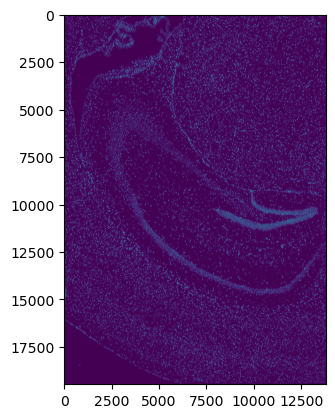

In [24]:
image = imread(r"C:\Users\mdichgan\Documents\Helmholtz\send_to_Jakob\tif_images\background.tiff")
plt.imshow(image)

In [ ]:
#plot cell nuclei allignment
df = adata_exp0.obs
x_min, x_max, y_max, y_min = 11000, 12000, 12000, 11000

fig, ax = plt.subplots()
ax.axis([x_min, x_max, y_max, y_min])        
ax.imshow(image,cmap = "binary_r") 

#filter spots
df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]

ax.scatter(df['x'], df['y'], s = 0.6, color = "red")

In [22]:
def plot_spots(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, show_ticks: bool = False):
    """Plot gene spots.
     
     Spot is red if entry in 'spot_assignment' is "spot in wrong celltype", blue if "spot in correct celltype", grey if "unassigned", green if "no negative marker".

     Parameters
     ----------
     adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
     x_min : int, x_max : int, y_min : int, y_max : int 
          crop coordinates
     image : NDArray
          read from image of dapi stained cell-nuclei
     show_ticks : bool 
          default False, show no ticks or labels
    """

    df = adata_sp.uns["spots"]
    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()
    
    
    s_factor =  150000/((x_max-x_min)**2)                  

    plt.axis([x_min, x_max, y_max, y_min])        
    plt.imshow(image,cmap = "binary_r") 

    #filter spots
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]
    
    
    plt.scatter(df.loc[df['spot_assignment']=="unassigned","x"],df.loc[df['spot_assignment']=="unassigned","y"], s = 0.3*s_factor, color = "grey", label = "unassigned")
    plt.scatter(df.loc[df['spot_assignment']=="spot in correct celltype","x"],df.loc[df['spot_assignment']=="spot in correct celltype","y"], s = 0.5*s_factor, color = "blue", label = "spot in correct celltype")
    plt.scatter(df.loc[df['spot_assignment']=="spot in wrong celltype","x"],df.loc[df['spot_assignment']=="spot in wrong celltype","y"], s = 1*s_factor, color = "red", label = "spot in wrong celltype")
    plt.scatter(df.loc[df['spot_assignment']=="no negative marker","x"],df.loc[df['spot_assignment']=="no negative marker","y"], s = 1*s_factor, color = "green", label = "no negative marker")
    
    lgnd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1, markerscale=2, frameon=False)

    #fix size of legend spots 
    lgnd.legend_handles[0]._sizes = [10]
    lgnd.legend_handles[1]._sizes = [10]
    lgnd.legend_handles[2]._sizes = [10]
    lgnd.legend_handles[3]._sizes = [10]

    if not show_ticks:
        plt.tick_params(which='both', bottom=False, left=False, labelbottom = False, labelleft = False)
    

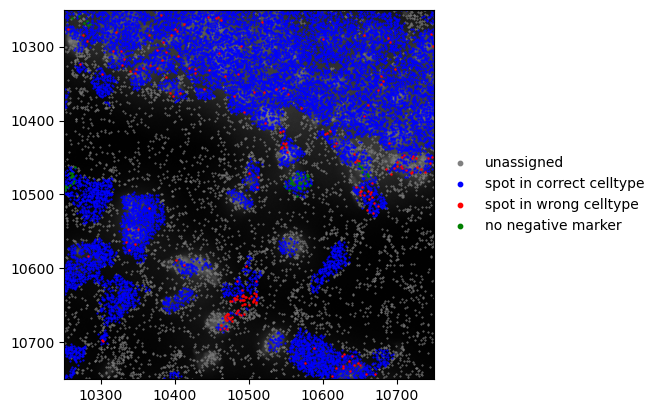

In [27]:
plot_spots(adata_exp0, 10250,10750,10250,10750,image,show_ticks=True)

In [11]:
def get_wrong_spot_ratio(adata_sp : AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """Get ratio array of spots in wrong celltype.

    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        ratio: spots in wrong celltype over spots in correct celltype or no negative marker spots
    range : range of binning 
    """
    df = adata_sp.uns["spots"]
    np.seterr(invalid='ignore')

    range = check_crop_exists(x_min,x_max,y_min,y_max,image)

    true_spots = df.loc[(df['spot_assignment'] == "spot in correct celltype") | (df['spot_assignment'] == "no negative marker")]
    H_t = np.histogram2d(true_spots['x'], true_spots['y'], bins, range)[0].T

    spots_in_wrong_ct = df.loc[df['spot_assignment'] == "spot in wrong celltype"]
    H_w = np.histogram2d(spots_in_wrong_ct['x'], spots_in_wrong_ct['y'], bins, range)[0].T

    H = H_w/(H_t+H_w)       #ignore "Unassigned" spots in density calculation, since it could be both assigned correctly or wrongly
    H[np.isnan(H)] = 0      #no negative marker wrongly assigned where no spots

 
    return H,range
    

In [118]:
A,r = get_wrong_spot_ratio(adata_exp0,10000,12500,10000,12500,image=None,bins = 20)
A

array([[0.00578369, 0.0030303 , 0.0120614 , 0.0017301 , 0.0075188 ,
        0.        , 0.        , 0.        , 0.02040816, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00810811, 0.00456882, 0.00864398, 0.00536673, 0.00229709,
        0.00314465, 0.03146853, 0.08311688, 0.        , 0.        ,
        0.        , 0.        , 0.1       , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.01538462, 0.01822917, 0.01314708, 0.01403679, 0.00310009,
        0.0055371 , 0.00895208, 0.00376952, 0.00391236, 0.00238663,
        0.00121803, 0.00160514, 0.00331675, 0.00426439, 0.00170068,
        0.00322061, 0.00277778, 0.00211864, 0.0055991 , 0.00729335],
       [0.06493506, 0.01328904, 0.        , 0.00869565, 0.02243211,
        0.02538787, 0.01990391, 0.00767868, 0.00920028, 0.00708661,
        0.00701754, 0.00420463, 0.00248911, 0

In [119]:
def plot_wrong_spot_ratio(adata_sp : AnnData, x_min: int, x_max: int, y_min: int, y_max: int,
                       image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False): 
    """Plot density of spots in wrong celltype.

    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """

    matrix, range = get_wrong_spot_ratio(adata_sp,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()
    
    title = "spots in wrong celltype density"
    vmin, vmax = [0,1]
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, vmin, vmax, smooth, show_ticks)



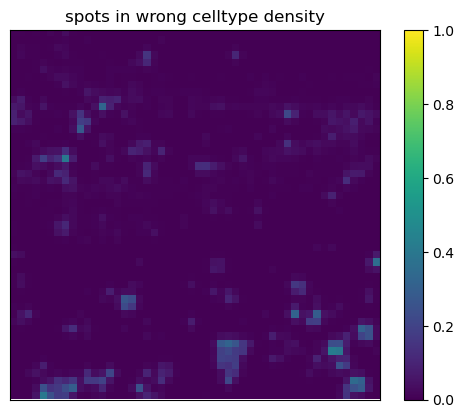

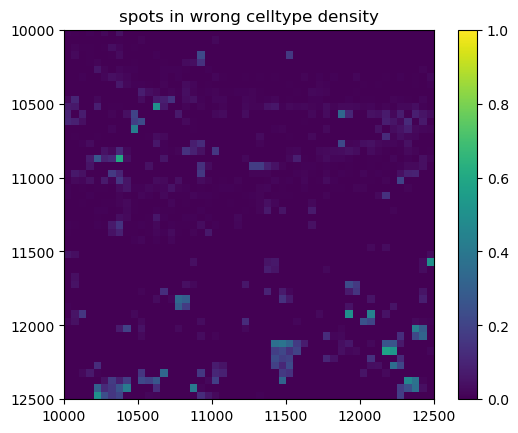

In [120]:
plot_wrong_spot_ratio(adata_exp0,10000,12500,10000,12500,image=None,bins = 50, smooth=0.5)
plot_wrong_spot_ratio(adata_exp0,10000,12500,10000,12500,image=None,bins = 50, show_ticks=True)

In [12]:
def get_spot_density(adata_sp : AnnData, spot_types: List[str], x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """Get density of specified spot types ("spot in wrong celltype", "spot in correct celltype", "unassigned", "no negative marker")

    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    spot_types: list['str']
        specify, which spot types ("spot in wrong celltype", "spot in correct celltype", "unassigned", "no negative marker") should be included in calculation
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        density of specified spottypes reads per bin
    range : range of binning 
    """
    df = adata_sp.uns["spots"]

    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    
    spots = df.loc[df['spot_assignment'].isin(spot_types)]          
    H = np.histogram2d(spots['x'], spots['y'], bins, range)[0].T

    return H, range


In [122]:
get_spot_density(adata_exp0,["spot in wrong celltype", "spot in correct celltype"],10000,12500,10000,12500,image=None,bins = 20)


(array([[1.729e+03, 1.643e+03, 9.120e+02, 5.780e+02, 1.330e+02, 0.000e+00,
         1.800e+01, 1.130e+02, 4.900e+01, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [3.700e+02, 1.751e+03, 1.851e+03, 1.677e+03, 1.306e+03, 6.360e+02,
         2.860e+02, 3.850e+02, 1.710e+02, 0.000e+00, 0.000e+00, 0.000e+00,
         2.000e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [6.500e+01, 3.840e+02, 1.211e+03, 2.066e+03, 2.258e+03, 1.806e+03,
         1.899e+03, 1.857e+03, 1.278e+03, 4.190e+02, 8.210e+02, 6.230e+02,
         6.030e+02, 4.690e+02, 5.880e+02, 6.210e+02, 3.600e+02, 9.440e+02,
         8.860e+02, 1.234e+03],
        [7.700e+01, 2.820e+02, 2.430e+02, 1.150e+02, 8.220e+02, 1.410e+03,
         1.457e+03, 1.693e+03, 1.413e+03, 1.270e+03, 1.425e+03, 1.427e+03,
         1.607e+03, 1.827e+03, 1.834e+03, 1.883e+03, 1.911e+03, 2.003e+03,
    

In [124]:
def plot_spot_density(adata_sp : AnnData, spot_types: list, x_min: int, x_max: int, y_min: int, y_max: int,
                      image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    """Plot density of specified spot types ("spot in wrong celltype", "spot in correct celltype", "unassigned", "no negative marker").

    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    spot_types: list[str]                    
        specify, which spot types ("spot in wrong celltype", "spot in correct celltype", "unassigned", "no negative marker") should be included in calculation
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    matrix, range = get_spot_density(adata_sp,spot_types,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()
    
    spot_types_str = '-/'.join([f"'{spot}'" for spot in spot_types])
    title = f"density of {spot_types_str} spots"        
    vmin, vmax = [0,None]
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, vmin, vmax, smooth, show_ticks)

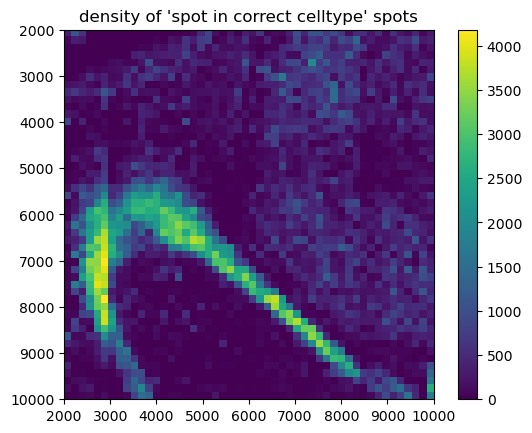

In [125]:
plot_spot_density(adata_exp0,["spot in correct celltype"],2000,10000,2000,10000,image=None,bins = 50, show_ticks=True)

In [13]:
def get_cell_density(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """Get cell density.

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        density of cells per bin
    range : range of binning 
    """
     
    df_cells = adata_sp.obs 
    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    
    H = np.histogram2d(df_cells['x'], df_cells['y'], bins, range)[0].T

    return H, range

In [52]:
get_cell_density(adata_exp0,10000,12500,10000,12500,image=None,bins = 20)

(array([[3., 2., 4., 2., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [1., 3., 3., 4., 3., 3., 2., 2., 1., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [1., 3., 5., 4., 4., 3., 5., 4., 3., 1., 4., 3., 2., 1., 2., 2.,
         1., 4., 3., 3.],
        [2., 1., 0., 0., 5., 5., 5., 1., 6., 3., 3., 3., 3., 5., 2., 2.,
         3., 2., 1., 3.],
        [3., 3., 4., 2., 2., 1., 2., 2., 2., 2., 1., 2., 2., 3., 3., 4.,
         2., 6., 4., 4.],
        [1., 2., 2., 4., 2., 2., 1., 1., 0., 1., 2., 1., 2., 1., 2., 1.,
         0., 4., 4., 5.],
        [1., 2., 3., 3., 0., 3., 2., 2., 1., 0., 2., 0., 2., 2., 4., 7.,
         7., 4., 5., 4.],
        [2., 3., 1., 2., 1., 1., 0., 3., 1., 2., 4., 5., 6., 4., 3., 3.,
         2., 3., 9., 2.],
        [3., 4., 3., 4., 4., 6., 4., 5., 4., 2., 3., 4., 3., 3., 3., 3.,
         3., 2., 1., 0.],
        [2., 3., 3., 5., 4., 3., 3., 2., 3., 2., 7., 6., 1., 1., 0., 0.,
         0., 2., 1., 1.],
        [3

In [128]:
def plot_cell_density(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int,
                      image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    """Plot cell density.

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """

    matrix, range = get_cell_density(adata_sp,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()

    title = "cell density"
    
    vmin, vmax = [0,None]
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, vmin, vmax, smooth, show_ticks)

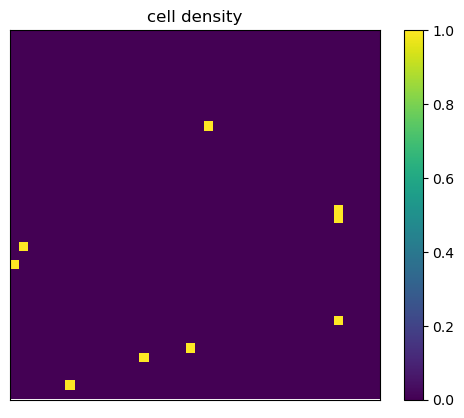

In [129]:
plot_cell_density(adata_exp0,11500,12000,11500,12000,image=None,bins = 40)

In [14]:
def get_celltype_density(adata_sp: AnnData, celltype: str, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """Get celltype density.

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    celltype: str
        celltype
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        density of celltype per bin
    range : range of binning 
    """
    df =  adata_sp.obs
    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    
    H_total = np.histogram2d(df['x'],df['y'], bins, range)[0]

    df = df.loc[df["celltype"]==celltype]

    H_celltype = np.histogram2d(df['x'],df['y'], bins, range)[0]

    H = H_celltype/H_total
    H[np.isnan(H)] = 0     #0 cells therefore also 0% celltype in the respective area
    H = H.T
    
    return H, range

In [131]:
get_celltype_density(adata_exp0,"CA3", 10000,12500,10000,12500,image=None,bins = [10,20])[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.11111111, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.33333333, 0.5       , 0.        , 0.        , 0.5       ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.33333333, 0.16666667, 0.25      , 0.        , 0.        ,
        0.33333333, 0.66666667, 0.        , 0.        , 0.        ],
       [0.        , 0.16666667, 0.33333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [132]:
def plot_celltype_density(adata_sp: AnnData, celltypes: list, x_min: int, x_max: int, y_min: int, y_max: int,
                      image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    """Plot cell density

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    celltypes : list[str]
        list of celltypes
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    number_of_celltypes = len(celltypes)
    
    for i in range(number_of_celltypes):
        matrix, range_ = get_celltype_density(adata_sp,celltypes[i],x_min,x_max,y_min,y_max,image,bins)
        x_min, x_max, y_min, y_max = np.ravel(range_).tolist()
        title = f"{celltypes[i]} density"
        vmin, vmax = [0,None]
        matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, vmin, vmax, smooth, show_ticks)

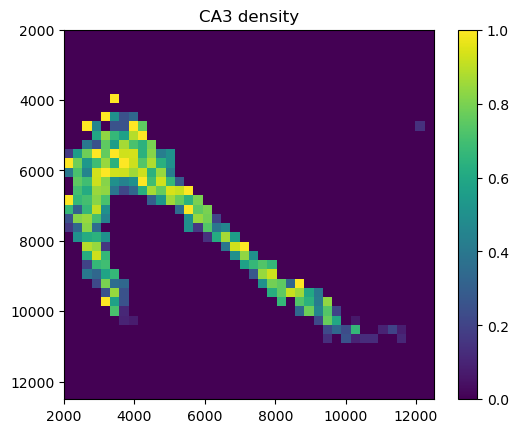

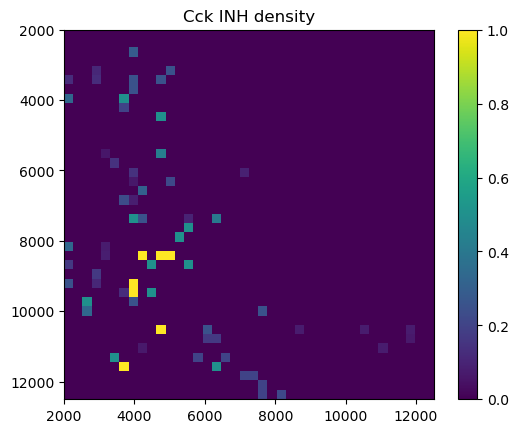

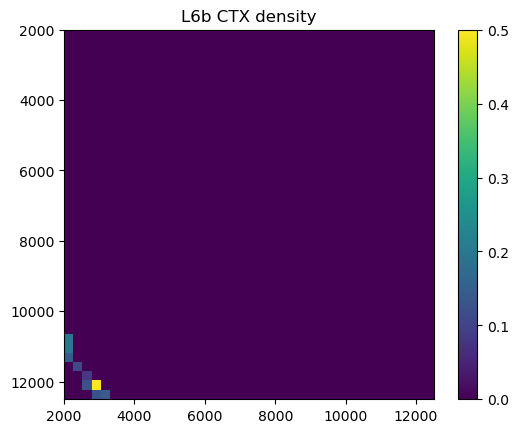

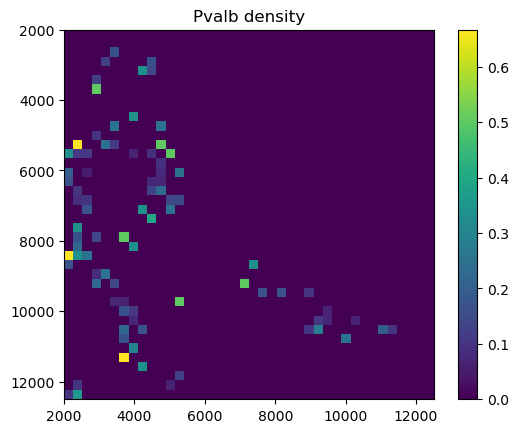

In [133]:
plot_celltype_density(adata_exp0,["CA3","Cck INH","L6b CTX","Pvalb"], 2000,12500,2000,12500,image=None,bins = [40,40],show_ticks=True)

In [ ]:
a = np.zeros((2,2,3))
a[0,...] = np.array([[1.0,1,1],[1,1,1]])
a[1,...] = np.array([[0,1,0],[2,0,3]])
print(a)
b = np.max(a, axis = 0)
print(b)
c = np.argmax(a,axis=0)
print(c)
print(np.dtype(c[1,0]))
z = ['a','b']

result = np.take(z,c)
print(result)

In [15]:
def get_number_of_celltypes(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins: Tuple[int,int]):
    """Get number of celltypes
    
    Parameters
    ---------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    Returns
    -------
    H : array of floats
        number of celltypes per bin
    range : range of binning 
    """
    
    range_ = check_crop_exists(x_min,x_max,y_min,y_max,image)
    
    celltypes = adata_sp.obs["celltype"].unique()  
    A = np.zeros((len(celltypes),bins[0],bins[1]))   

    for i in range(len(celltypes)):
        A[i,...] = get_celltype_density(adata_sp, celltypes[i],x_min,x_max,y_min,y_max,image,bins)[0]
    A = sum(A>0)
    
    return A, range_

In [135]:
get_number_of_celltypes(adata_exp0,10000,12500,10000,12500,image=None,bins = [20,20])[0]

array([[1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 2, 3, 3, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 4, 4, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1],
       [1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 3, 2, 1, 1, 2, 3, 3],
       [1, 2, 2, 3, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 4, 3, 3],
       [1, 2, 2, 3, 0, 2, 1, 1, 1, 0, 2, 0, 2, 2, 4, 4, 3, 2, 2, 1],
       [2, 2, 1, 2, 1, 1, 0, 2, 1, 2, 4, 3, 2, 1, 1, 1, 1, 1, 3, 1],
       [1, 2, 2, 2, 3, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0],
       [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 0, 0, 0, 2, 1, 1],
       [1, 1, 2, 1, 1, 2, 1, 3, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1],
       [1, 0, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 2, 2, 1, 0, 0,

In [136]:
def plot_number_of_celltypes(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins: Tuple[int,int], smooth: float = 0, show_ticks: bool = False):    
    """Plot number of celltypes
    
    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    matrix, range = get_number_of_celltypes(adata_sp,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()
    
    title = "number of celltypes"
    vmin, vmax = [0,None]
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, vmin, vmax, smooth, show_ticks)

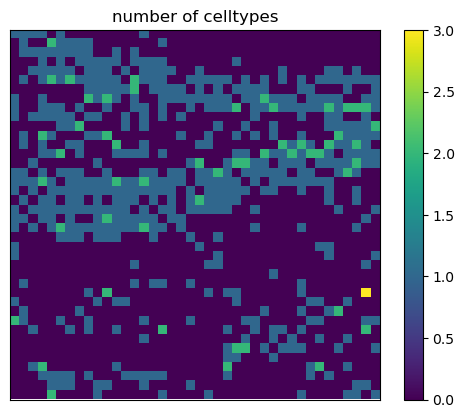

In [137]:
plot_number_of_celltypes(adata_exp0,10000,12500,10000,12500,image=None,bins = [40,40])

In [16]:
def get_major_celltype_perc(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins: Tuple[int,int]):
    """Get major celltype percentage.
    
    Parameters
    ---------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    Returns
    -------
    H : array of floats
        major celltype percentage
    range : range of binning 
    """
    range_ = check_crop_exists(x_min,x_max,y_min,y_max,image)
    
    celltypes = adata_sp.obs["celltype"].unique()
    A = np.zeros((len(celltypes),bins[0],bins[1]))   
    
    for i in range(len(celltypes)):
        A[i,...] = get_celltype_density(adata_sp, celltypes[i],x_min,x_max,y_min,y_max,image,bins)[0]
    B = np.max(A,axis=0)

    return B, range_

In [139]:
get_major_celltype_perc(adata_exp0,10000,12500,10000,12500,image=None,bins = [20,20])[0]

array([[1.        , 1.        , 0.75      , 1.        , 1.        ,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.66666667, 0.6       , 0.5       , 1.        ,
        1.        , 0.8       , 1.        , 0.66666667, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.        , 0.        , 0.4       ,
        0.4       , 0.4       , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0

In [140]:
def plot_major_celltype_perc(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins: Tuple[int,int], smooth: float = 0, show_ticks: bool = False):    
    """Plot major celltype percentage.

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    
    matrix, range = get_major_celltype_perc(adata_sp,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()

    title = "major celltype percentage"
    vmin, vmax = [0,None]
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, vmin, vmax, smooth, show_ticks)

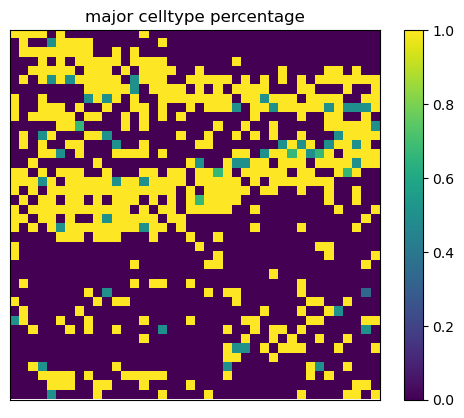

In [141]:
plot_major_celltype_perc(adata_exp0,10000,12500,10000,12500,image=None,bins = [40,40])

In [17]:
def get_summed_cell_area(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins: Tuple[int,int]):
    """Get summed cell area.
    
    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    Returns
    -------
    H : array of floats
        summed cell area
    range : range of binning 
    """
    df = adata_sp.obs
    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()

    #filter cells
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]

    bins_x = np.digitize(df['x'], np.linspace(x_min, x_max, bins[0] + 1)) -1
    bins_y = np.digitize(df['y'], np.linspace(y_min, y_max, bins[1] + 1)) -1

    groups = df.groupby([bins_x, bins_y])
    sums = groups['area'].sum()
    summed_cell_area = np.zeros((bins[0],bins[1]))

    for (i,j), value in sums.items():
        summed_cell_area[i,j] = value
    
    return summed_cell_area.T, range

In [143]:
get_summed_cell_area(adata_exp0,10000,12500,10000,12500,image=None,bins = [20,20])[0]

array([[20114.   ,  7662.   ,  7952.5  , 13476.   ,   319.4  ,     0.   ,
            0.   ,  1579.   ,   580.   ,     0.   ,     0.   ,     0.   ,
            0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
            0.   ,     0.   ],
       [  292.7  , 22551.   , 12193.4  , 10913.6  , 14258.   ,  6167.   ,
         1649.   ,  2954.   ,  1401.   ,     0.   ,     0.   ,     0.   ,
          136.6  ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
            0.   ,     0.   ],
       [  888.3  ,  2496.   , 10549.9  , 15155.9  , 23313.   , 11074.   ,
        14920.4  , 17644.   , 11778.5  ,  2594.   , 13111.54 ,  6657.   ,
         5829.   ,  3071.   , 10039.2  ,  8315.   ,  2412.   ,  9422.3  ,
        12323.6  , 11233.   ],
       [  545.1  ,  2511.   ,     0.   ,     0.   ,  3668.1  ,  8561.2  ,
        19068.7  ,  8972.   , 17552.3  , 15656.   , 15695.   , 15288.   ,
        13268.   , 22953.5  ,  8322.   ,  9804.   , 13853.   , 13083.   ,
         5542.   , 

In [144]:
def plot_summed_cell_area(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins: Tuple[int,int], smooth: float = 0, show_ticks: bool = False):
    """Plot summed cell area.

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """

    matrix, range = get_summed_cell_area(adata_sp,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()

    title = "summed cell area"
    vmin, vmax = [0,None]
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, vmin, vmax, smooth, show_ticks)

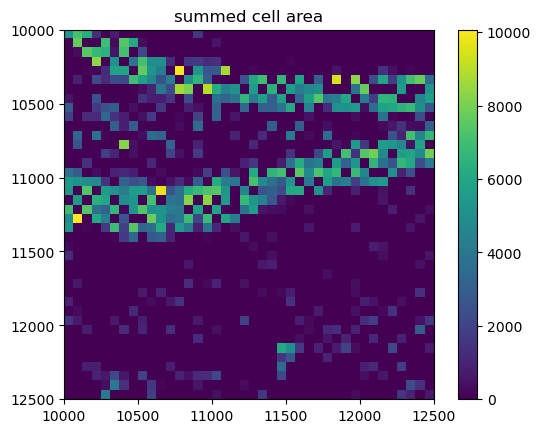

In [145]:
plot_summed_cell_area(adata_exp0,10000,12500,10000,12500,image=None,bins = [40,40], show_ticks=True)

In [18]:
def get_avg_knn_mixing(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, 
                       image: np.ndarray, bins: Tuple[int,int]):
    """Get average knn mixing score.
    
    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    Returns
    -------
    H : array of floats
        average knn mixing score
    range : range of binning 
    """

    df = adata_sp.obs
    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()

    #filter spots
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]

    bins_x = np.digitize(df['x'], np.linspace(x_min, x_max, bins[0] + 1)) -1
    bins_y = np.digitize(df['y'], np.linspace(y_min, y_max, bins[1] + 1)) -1

    groups = df.groupby([bins_x, bins_y])
    nanmean = groups['score'].mean()            #?better with np.nanmean()
    average_knn_mixing_score = np.zeros((bins[0],bins[1]))

    for (i,j), value in nanmean.items():
        average_knn_mixing_score[i,j] = value
    
    return average_knn_mixing_score.T, range

    

In [147]:
get_avg_knn_mixing(adata_exp0,10000,12500,10000,12500,image=None,bins = [20,20])[0]

array([[0.0247619 , 0.03769166, 0.09914673, 0.        , 0.09109023,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.01191375, 0.        , 0.03788571,
        0.06314286, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.10062738, 0.01503401, 0.02059006,
        0.12811594, 0.1918419 , 0.09188699, 0.05490683, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.06071429,
        0.        , 0.        , 0.05759653, 0.24396104, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.10734286, 0.25747573, 0.20559563, 0.00841905,
        0.01010286, 0.        , 0.01127551, 0

In [149]:
def plot_avg_knn_mixing(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins: Tuple[int,int], smooth: float = 0, show_ticks: bool = False):
    """Plot avg knn mixing

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """

    matrix, range = get_avg_knn_mixing(adata_sp,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()

    title = "average knn mixing"
    vmin, vmax = [0,1]
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, vmin, vmax, smooth, show_ticks)

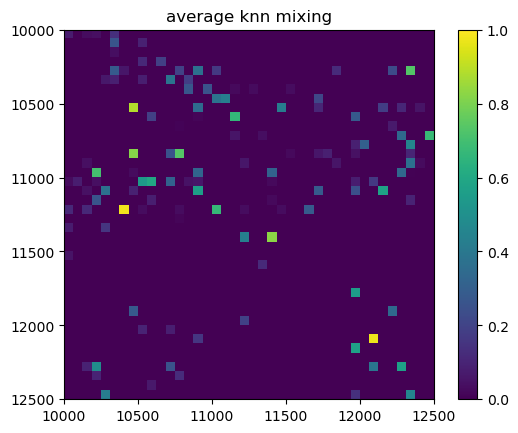

In [150]:
plot_avg_knn_mixing(adata_exp0,10000,12500,10000,12500,image=None,bins = [40,40], show_ticks=True)

In [19]:
def relative_expression_similarity_across_genes_local(
    adata_sp : AnnData, 
    adata_sc : AnnData,
    x_min : int, 
    x_max : int, 
    y_min : int, 
    y_max : int, 
    image : np.ndarray, 
    bins : int = 10,            #wie in np.histogram2d, oder anderes Typing?
    key : str='celltype', 
    layer : str='lognorm',
    min_total_cells : int = 1,      #welche Werte?
    min_n_cells_per_ct : int = 1
    ):

    """Caculate in each gridfield the relative expression similarity across genes. 
    
    If too few cells are in a gridfield, we assign NaN. Further we only include
    celltypes with enough cells per celltype.

    Parameters
    ----------
    adata_sp : AnnData
        annotated ``AnnData`` object with counts from spatial data
    adata_sc : AnnData
        annotated ``AnnData`` object with counts scRNAseq data
    x_min : int, 
    x_max : int, 
    y_min : int, 
    y_max : int, 
    image : np.ndarray, 
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    key : str='celltype', optional
        name of the column containing the cell type information
    layer : str='lognorm'
    min_total_cells: int, optional
        if less than min_total_cells cells are provided, NaN is assigned. By default 1
    min_n_cells_per_ct: int, optional
        only celltypes with at least min_n_cells_per_ct members are considered. By default 1

    Returns
    -------
    gridfield_metric: array of floats  
    """

    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    bins_x, bins_y = get_bin_edges(range, bins)

    n_bins_x = len(bins_x) - 1
    n_bins_y = len(bins_y) - 1

    ### SET UP
    # set the .X layer of each of the adatas to be log-normalized counts
    adata_sp.X = adata_sp.layers[layer]
    adata_sc.X = adata_sc.layers[layer]

    # take the intersection of genes in adata_sp and adata_sc, as a list
    intersect_genes = list(set(adata_sp.var_names).intersection(set(adata_sc.var_names)))
    n_intersect_genes = len(intersect_genes)

    # subset adata_sc and adata_sp to only include genes in the intersection of adata_sp and adata_sc 
    adata_sc=adata_sc[:,intersect_genes]
    adata_sp=adata_sp[:,intersect_genes]

    # CPM-Normalization                                 causes the warnings
    sc.pp.normalize_total(adata_sp,target_sum=1e6)
    sc.pp.normalize_total(adata_sc,target_sum=1e6)
            
    # find the intersection of unique celltypes in adata_sc and adata_sp
    intersect_celltypes = list(set(adata_sp.obs["celltype"]).intersection(set(adata_sc.obs["celltype"])))

    adata_sc = adata_sc[adata_sc.obs[key].isin(intersect_celltypes), :]
    adata_sp = adata_sp[adata_sp.obs[key].isin(intersect_celltypes), :]

    sp_X = adata_sp.X.toarray()
    exp_sp = pd.DataFrame(sp_X,columns=intersect_genes)
    exp_sp.index = adata_sp.obs.index

    gridfield_metric = np.zeros((n_bins_y,n_bins_x))

    i, j = 0, 0
    for x_start, x_end in zip(bins_x[:-1], bins_x[1:]):
        i = 0
        for y_start, y_end in zip(bins_y[:-1], bins_y[1:]):    
            #hat adata_sp.obs immer x, y Koord? Sonst mit get_cells_location Funktion
            df = adata_sp.obs[["x", "y"]]
            df = df[
            (df["x"] >= x_start)
            & (df["x"] < x_end)
            & (df["y"] >= y_start)
            & (df["y"] < y_end)
            ]

            if len(df) < min_total_cells:
                gridfield_metric[i,j] = np.nan   
                i += 1
                continue  

            sp_local = exp_sp.loc[df.index,:] 
            sp_local[key] = adata_sp.obs.loc[df.index,:][key]           #wieso nicht vor der for-Schleife?

            n_cells_per_ct = sp_local[key].value_counts()
            eligible_ct = n_cells_per_ct.loc[n_cells_per_ct >= min_n_cells_per_ct].index.tolist()

            sp_local = sp_local.loc[sp_local[key].isin(eligible_ct),:]
            sum_sp_local = np.sum(np.sum(sp_local.iloc[:,:-1]))

            adata_sc_local = adata_sc[adata_sc.obs[key].isin(eligible_ct), :]
            sc_X = adata_sc_local.X.toarray()
            sc_local = pd.DataFrame(sc_X, columns = intersect_genes)
            sc_local.index = adata_sc_local.obs.index
            sc_local[key] = adata_sc_local.obs[key]
            sum_sc_local = np.sum(np.sum(sc_local.iloc[:,:-1]))

            if sum_sp_local != 0:
                mean_celltype_sp_normalized=(sp_local.groupby(key).mean().dropna())*(n_intersect_genes)**2     #why still e.g. Meis2 in df? (dropna)
            else: 
                mean_celltype_sp_normalized=0

            if sum_sc_local != 0:
                mean_celltype_sc_normalized=(sc_local.groupby(key).mean().dropna())*(n_intersect_genes)**2
            else: 
                mean_celltype_sc_normalized=0

            mean_celltype_sp_normalized=mean_celltype_sp_normalized.to_numpy()
            pairwise_diff_sp = mean_celltype_sp_normalized[:,:,np.newaxis] - mean_celltype_sp_normalized[:,np.newaxis,:]

            mean_celltype_sc_normalized=mean_celltype_sc_normalized.to_numpy()
            pairwise_diff_sc = mean_celltype_sc_normalized[:,:,np.newaxis] - mean_celltype_sc_normalized[:,np.newaxis,:]

            delta = np.sum(np.abs(pairwise_diff_sp-pairwise_diff_sc))
            gridfield_metric[i,j]  = 1-delta/(2*np.sum(np.abs(pairwise_diff_sc)))
            i+=1
        j+=1     

    return gridfield_metric

In [ ]:
A = relative_expression_similarity_across_genes_local(adata_exp0,adata_Yao,10000,11500,10000,11500,image=None,bins=[20,20])

In [20]:
def relative_expression_similarity_across_cell_type_clusters(
    adata_sp : AnnData, 
    adata_sc : AnnData,
    x_min : int, 
    x_max : int, 
    y_min : int, 
    y_max : int, 
    image : np.ndarray, 
    bins : int = 10,
    key : str='celltype', 
    layer : str='lognorm',
    min_total_cells : int = 1,      #welche Werte?
    min_n_cells_per_ct : int = 1
    ):

    """Caculate in each gridfield the relative expression similarity across cell type clusters. 
    
    If too few cells are in a gridfield, we assign NaN. Further we only include
    celltypes with enough cells per celltype.

    Parameters
    ----------
    spatial_data : AnnData
        annotated ``AnnData`` object with counts from spatial data
    seq_data : AnnData
        annotated ``AnnData`` object with counts scRNAseq data
    x_min : int, 
    x_max : int, 
    y_min : int, 
    y_max : int, 
    image : np.ndarray, 
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    key : str
        name of the column containing the cell type information
    layer: str='lognorm'
    min_total_cells: int, optional
        if less than min_total_cells cells are provided, NaN is assigned. By default 50
    min_n_cells_per_ct: int, optional
        only celltypes with at least min_n_cells_per_ct members are considered. By default 10

    Returns
    -------
    gridfield_metric: array of floats  
    """

    
    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    bins_x, bins_y = get_bin_edges(range, bins)

    n_bins_x = len(bins_x) - 1
    n_bins_y = len(bins_y) - 1

    ### SET UP
    # set the .X layer of each of the adatas to be log-normalized counts
    adata_sp.X = adata_sp.layers[layer]
    adata_sc.X = adata_sc.layers[layer]

    # take the intersection of genes in adata_sp and adata_sc, as a list
    intersect_genes = list(set(adata_sp.var_names).intersection(set(adata_sc.var_names)))

    # subset adata_sc and adata_sp to only include genes in the intersection of adata_sp and adata_sc 
    adata_sc=adata_sc[:,intersect_genes]
    adata_sp=adata_sp[:,intersect_genes]

    # CPM-Normalization                                    causes the warnings
    sc.pp.normalize_total(adata_sp,target_sum=1e6)
    sc.pp.normalize_total(adata_sc,target_sum=1e6)
            
    # find the intersection of unique celltypes in adata_sc and adata_sp
    intersect_celltypes = list(set(adata_sp.obs["celltype"]).intersection(set(adata_sc.obs["celltype"])))
    n_intersect_celltypes = len(intersect_celltypes)

    adata_sc = adata_sc[adata_sc.obs[key].isin(intersect_celltypes), :]
    adata_sp = adata_sp[adata_sp.obs[key].isin(intersect_celltypes), :]

    sp_X = adata_sp.X.toarray()
    exp_sp = pd.DataFrame(sp_X,columns=intersect_genes)
    exp_sp.index = adata_sp.obs.index

    gridfield_metric = np.zeros((n_bins_y,n_bins_x))

    i, j = 0, 0
    for x_start, x_end in zip(bins_x[:-1], bins_x[1:]):
        i = 0
        for y_start, y_end in zip(bins_y[:-1], bins_y[1:]):    
            #hat adata_sp.obs immer x, y Koord? Sonst mit get_cells_location Funktion
            df = adata_sp.obs[["x", "y"]]
            df = df[
            (df["x"] >= x_start)
            & (df["x"] < x_end)
            & (df["y"] >= y_start)
            & (df["y"] < y_end)
            ]

            if len(df) < min_total_cells:
                gridfield_metric[n_bins_y-1-i,j] = np.nan   
                i += 1
                continue  

            sp_local = exp_sp.loc[df.index,:] 
            sp_local[key] = adata_sp.obs.loc[df.index,:][key]           #wieso nicht vor der for-Schleife?

            n_cells_per_ct = sp_local[key].value_counts()
            eligible_ct = n_cells_per_ct.loc[n_cells_per_ct >= min_n_cells_per_ct].index.tolist()

            sp_local = sp_local.loc[sp_local[key].isin(eligible_ct),:]
            sum_sp_local = np.sum(np.sum(sp_local.iloc[:,:-1]))

            adata_sc_local = adata_sc[adata_sc.obs[key].isin(eligible_ct), :]
            sc_X = adata_sc_local.X.toarray()
            sc_local = pd.DataFrame(sc_X, columns = intersect_genes)
            sc_local.index = adata_sc_local.obs.index
            sc_local[key] = adata_sc_local.obs[key]
            sum_sc_local = np.sum(np.sum(sc_local.iloc[:,:-1]))

            if sum_sp_local != 0:
                mean_celltype_sp_normalized=(sp_local.groupby(key).mean().dropna())*(n_intersect_celltypes)**2     #why still e.g. Meis2 in df? (dropna)
            else: 
                mean_celltype_sp_normalized=0

            if sum_sc_local != 0:
                mean_celltype_sc_normalized=(sc_local.groupby(key).mean().dropna())*(n_intersect_celltypes)**2
            else: 
                mean_celltype_sc_normalized=0

            mean_celltype_sp_normalized=mean_celltype_sp_normalized.T.to_numpy()
            pairwise_diff_sp = mean_celltype_sp_normalized[:,:,np.newaxis] - mean_celltype_sp_normalized[:,np.newaxis,:]

            mean_celltype_sc_normalized=mean_celltype_sc_normalized.T.to_numpy()
            pairwise_diff_sc = mean_celltype_sc_normalized[:,:,np.newaxis] - mean_celltype_sc_normalized[:,np.newaxis,:]

            delta = np.sum(np.abs(pairwise_diff_sp-pairwise_diff_sc))
            gridfield_metric[n_bins_y-1-i,j]  = 1-delta/(2*np.sum(np.abs(pairwise_diff_sc)))
            i+=1
        j+=1     

    return gridfield_metric

In [56]:
A = relative_expression_similarity_across_cell_type_clusters(adata_exp0,adata_Yao,10000,12000,10000,12000,image=None,bins=[20,20])

c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [57]:
A

array([[ 0.04031314,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan, -0.09044571,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,  

In [58]:
#Warnings: 
#ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.

def get_correlation_matrices(adata_sp: AnnData, adata_sc: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins: Tuple[int,int], celltype: str):
    """Get pearson and spearman correlation matrices.

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    adata_sc: AnnData
        Annotated ``AnnData`` object with counts scRNAseq data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    celltype : str
    
    Returns
    -------
        pearson and spearman correlation matrices, df with measurements
    """

    M_wrong_spot_ratio = get_wrong_spot_ratio(adata_sp,x_min, x_max, y_min, y_max,image,bins)[0]
    M_spot_density = get_spot_density(adata_sp,["spot in wrong celltype"],x_min, x_max, y_min, y_max,image,bins)[0]
    M_cell_density = get_cell_density(adata_sp,x_min, x_max, y_min, y_max,image,bins)[0]
    M_celltype_density = get_celltype_density(adata_sp,celltype, x_min, x_max, y_min, y_max,image,bins)[0] 
    M_number_of_celltypes = get_number_of_celltypes(adata_sp,x_min, x_max, y_min, y_max,image,bins)[0]
    M_major_celltype_perc = get_major_celltype_perc(adata_sp,x_min, x_max, y_min, y_max,image,bins)[0]
    M_summed_cell_area = get_summed_cell_area(adata_sp,x_min, x_max, y_min, y_max,image,bins)[0]
    M_avg_knn_mixing = get_avg_knn_mixing(adata_sp,x_min, x_max, y_min, y_max,image,bins)[0]
    M_relative_expression_similarity_across_genes_local = relative_expression_similarity_across_genes_local(adata_sp, adata_sc, x_min, x_max, y_min, y_max, image, bins)
    M_relative_expression_similarity_across_cell_type_clusters = relative_expression_similarity_across_cell_type_clusters(adata_sp, adata_sc, x_min, x_max, y_min, y_max, image, bins)
    measurements_df = pd.DataFrame({'wrong spot ratio':M_wrong_spot_ratio.flatten(), 'spot density': M_spot_density.flatten(), 
                                'cell density': M_cell_density.flatten(), 'celltype density': M_celltype_density.flatten(), 'number of celltypes': M_number_of_celltypes.flatten(),
                                'major celltype perc': M_major_celltype_perc.flatten(), 'summed cell area': M_summed_cell_area.flatten(),
                                'avg knn mixing': M_avg_knn_mixing.flatten(), 'relative expression similarity across genes local': M_relative_expression_similarity_across_genes_local.flatten(),
                                'relative expression similarity across cell type clusters': M_relative_expression_similarity_across_cell_type_clusters.flatten()
    })     
    
    n = measurements_df.shape[1]
    spearman_corr_matrix = np.zeros((n,n))
    pearson_corr_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            x, y = measurements_df.iloc[:,i], measurements_df.iloc[:,j]
            # Create a mask to filter out NaN values
            mask = ~np.isnan(x) & ~np.isnan(y)
            # Apply the mask to the data
            x_filtered = x[mask]
            y_filtered = y[mask]

            #pearsonr only defined if len(x_filtered) = len(y_filtered) >= 2
            if len(x_filtered)>=2:
                spearman_corr_matrix[i,j] = stats.spearmanr(x_filtered,y_filtered).statistic
                pearson_corr_matrix[i,j] = stats.pearsonr(x_filtered,y_filtered).statistic      
            else:
                spearman_corr_matrix[i,j] = np.nan
                pearson_corr_matrix[i,j] = np.nan  

        
        
        
    return pearson_corr_matrix, spearman_corr_matrix, measurements_df

In [69]:
pearson_corr_matrix, spearman_corr_matrix, measurements_df = get_correlation_matrices(adata_exp0,adata_Yao,10000,12000,10000,12000,image=None,bins = [20,20], celltype = "CA3")

c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a v

In [61]:
measurements_df

,wrong spot ratio,spot density,cell density,celltype density,number of celltypes,major celltype perc,summed cell area,avg knn mixing,relative expression similarity across genes local,relative expression similarity across cell type clusters
0,0.004382,5.0,1.0,0.0,1,1.0,5281.0,0.074286,0.130404,0.040313
1,0.003457,4.0,2.0,0.0,1,1.0,13482.0,0.017540,0.200303,NaN
2,0.001305,1.0,2.0,0.0,1,1.0,7875.0,0.020152,0.283443,NaN
3,0.004963,2.0,2.0,0.0,1,1.0,8169.5,0.067653,0.197040,NaN
4,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
395,0.018519,1.0,1.0,0.0,1,1.0,819.8,0.000000,0.098019,NaN
396,0.000000,0.0,1.0,0.0,1,1.0,213.0,0.000000,0.013844,NaN
397,0.021429,3.0,1.0,0.0,1,1.0,745.8,0.000000,0.085408,NaN
398,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.000000,NaN,NaN


In [63]:
def plot_correlation_matrices_and_pairplot(adata_sp,adata_sc,x_min,x_max,y_min,y_max,image,bins,celltype):
    """Plot pearson and spearman correlation matrices and a pairplot of all measurements.

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    adata_sc: AnnData
        Annotated ``AnnData`` object with counts scRNAseq data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension

    """
    
    pearson_corr_matrix, spearman_corr_matrix, measurements_df = get_correlation_matrices(adata_sp,adata_sc,x_min,x_max,y_min,y_max,image,bins,celltype)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title("measurements pearson-correlations", fontsize = 10)
    ax2.set_title("measurements spearman-correlations", fontsize = 10)
    plot1 = ax1.imshow(pearson_corr_matrix)
    plot2 = ax2.imshow(spearman_corr_matrix)

    labels = ["wrong spot ratio","spot density","cell density", "celltype density",
            "number of celltypes","major celltype perc","summed cell area", "avg knn mixing", "relative expression similarity across genes local",
            "relative expression similarity across cell type clusters"]
    for ax in [ax1,ax2]:
        ax.set_xticks(np.arange(len(labels)),labels)
        ax.set_yticks(np.arange(len(labels)),labels)
        ax.set_xticklabels(labels, rotation=90)
        ax.tick_params(axis="x",labelsize=8)
        ax.tick_params(axis="y",labelsize=8)
        
    fig.colorbar(plot1,fraction=0.046, pad=0.04)    
    fig.colorbar(plot2,fraction=0.046, pad=0.04)    

    plt.subplots_adjust(wspace=4)        #controls gap between two plots, to avoid overlaps of labels

    sns.set(font_scale=0.8)               
    sns.pairplot(measurements_df)

c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim_env\Lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a v

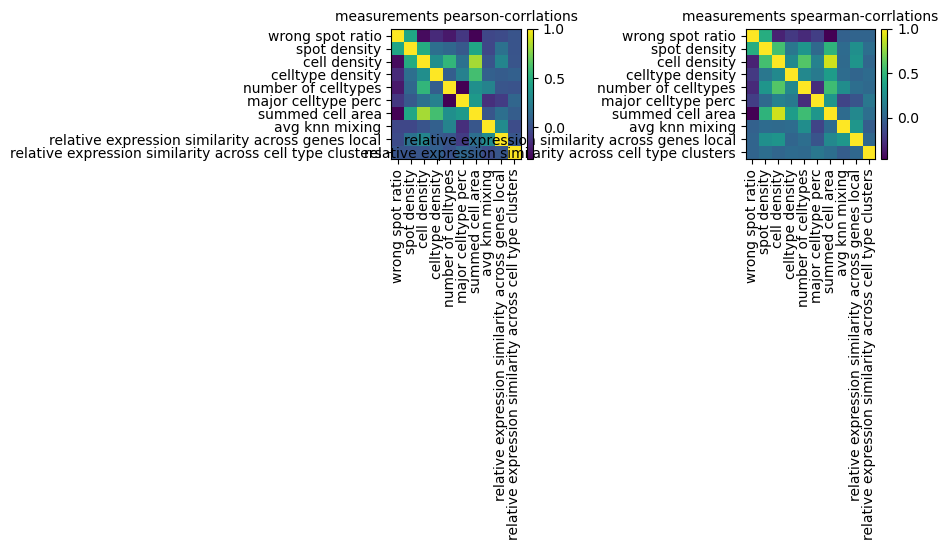

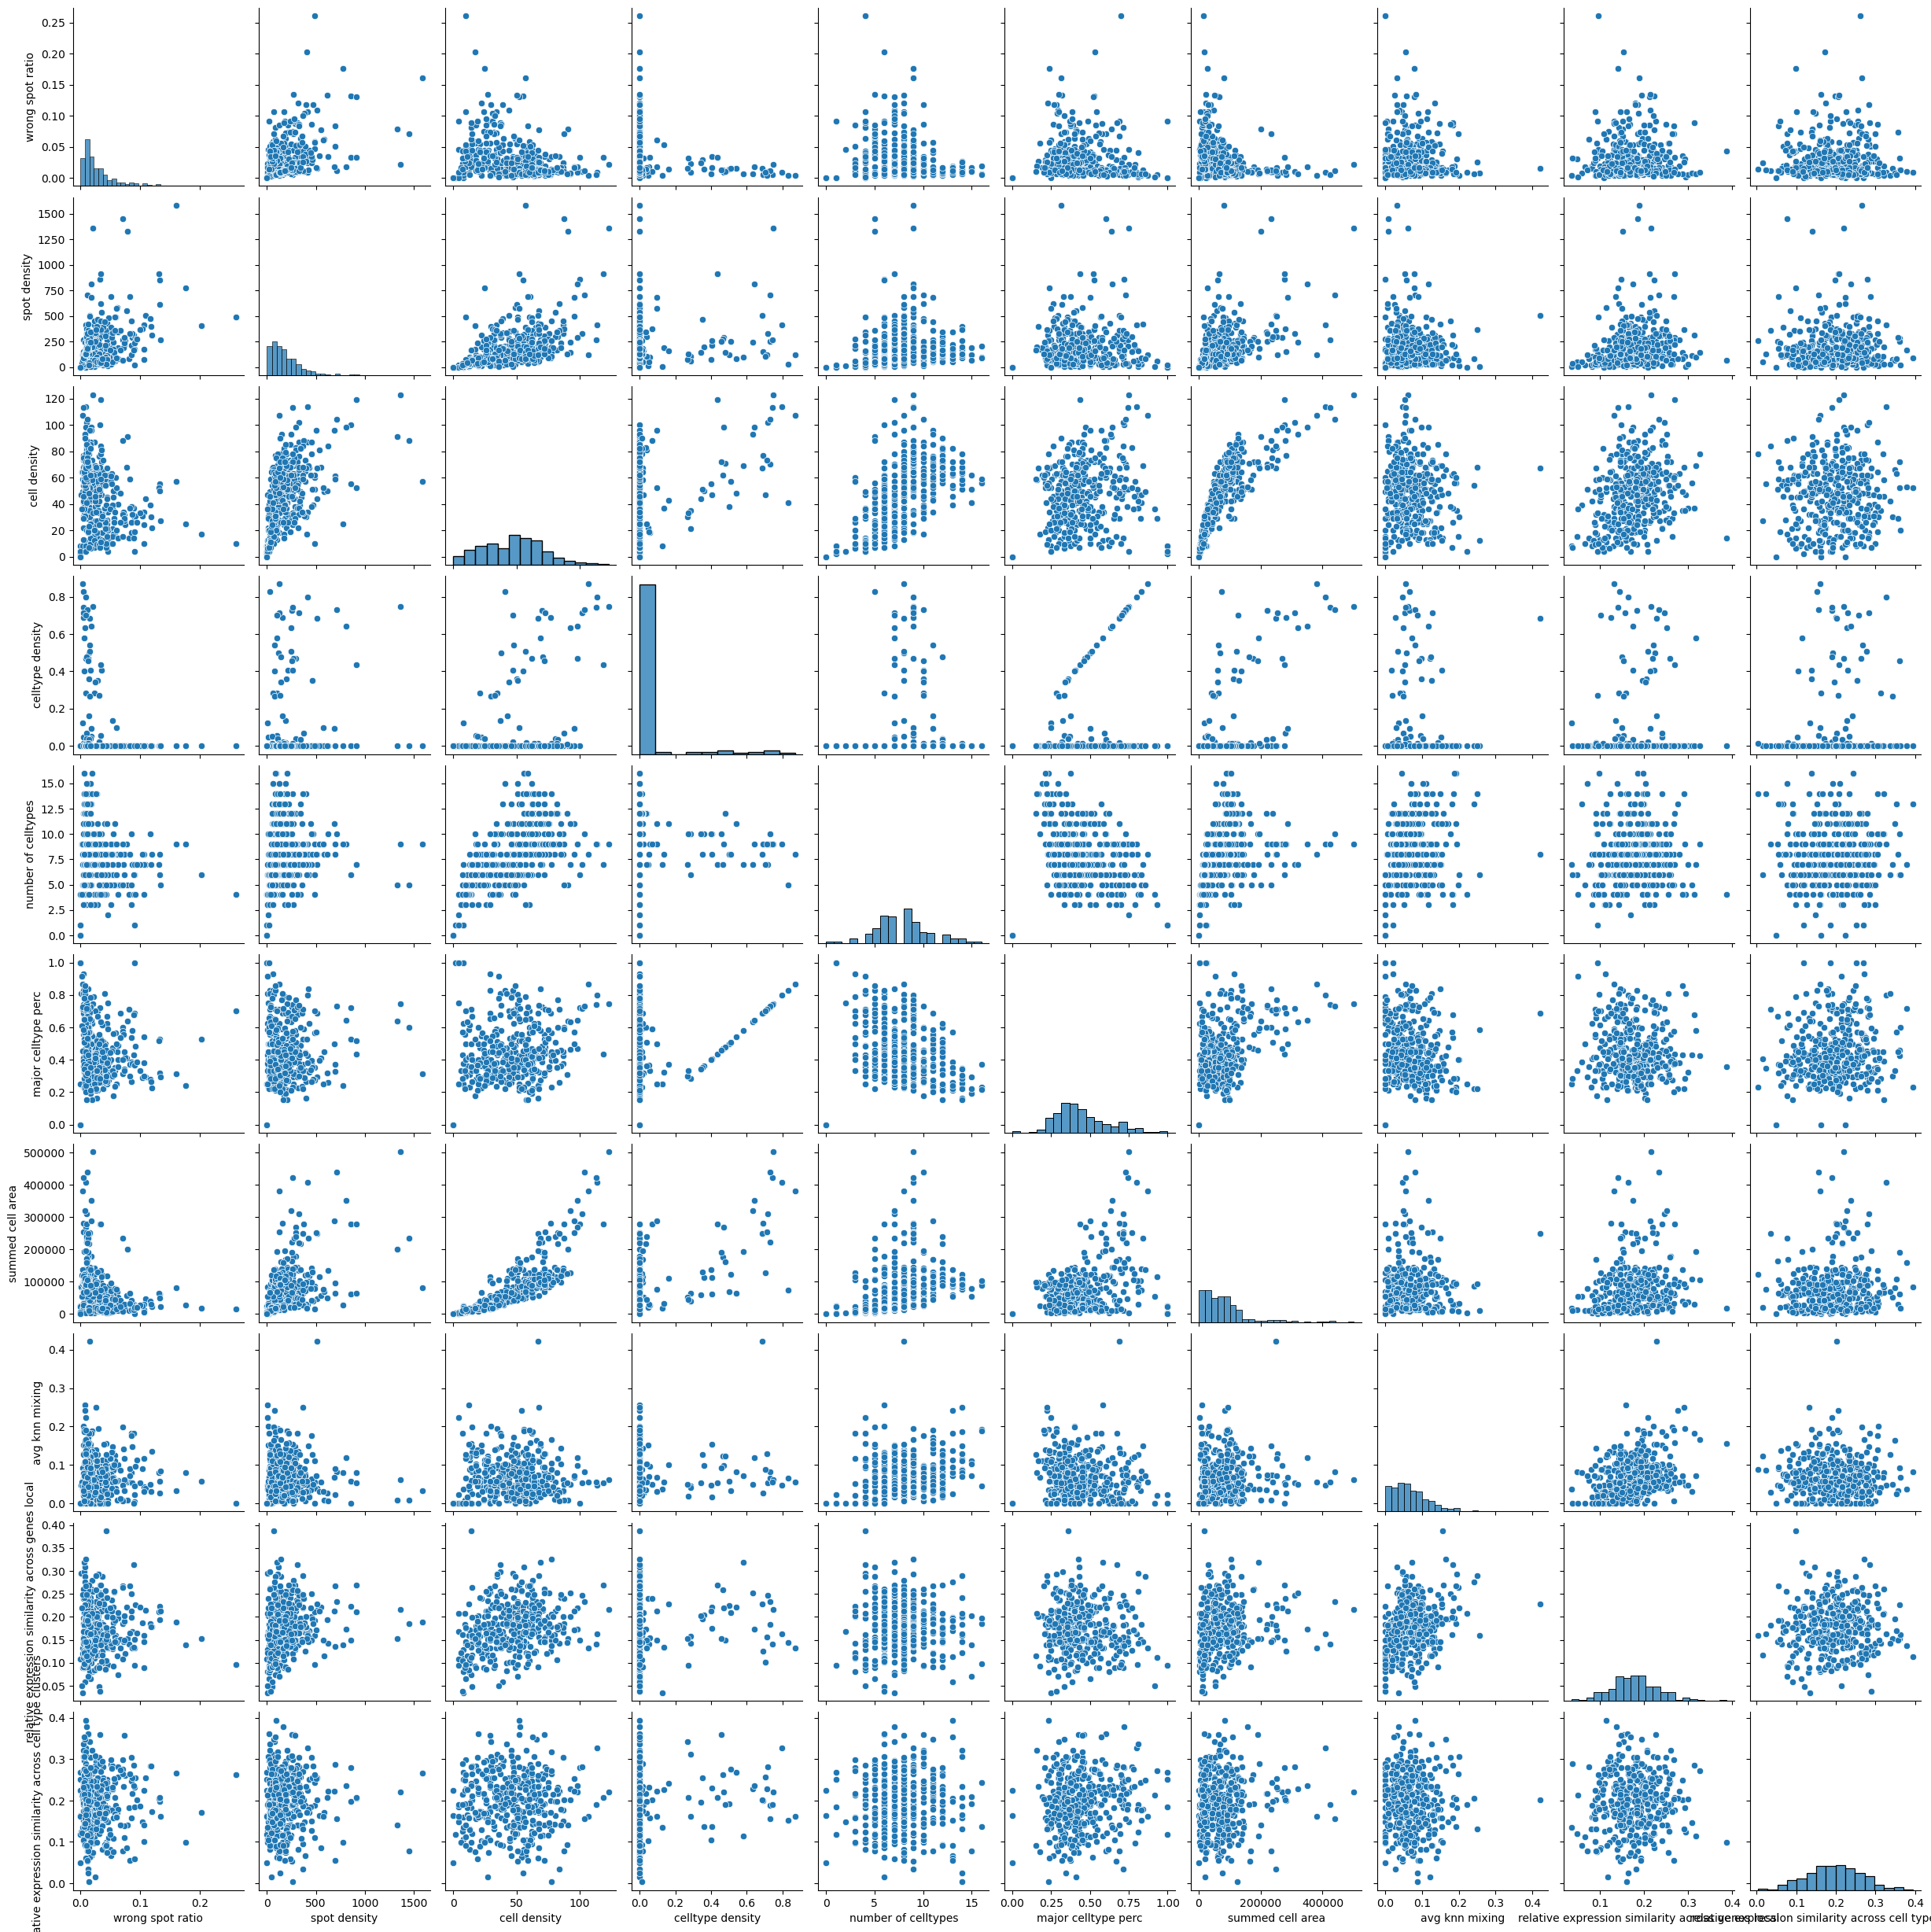

In [65]:
plot_correlation_matrices_and_pairplot(adata_exp0,adata_Yao,10000,12000,10000,12000,image=None,bins = [20,20], celltype = "CA3")

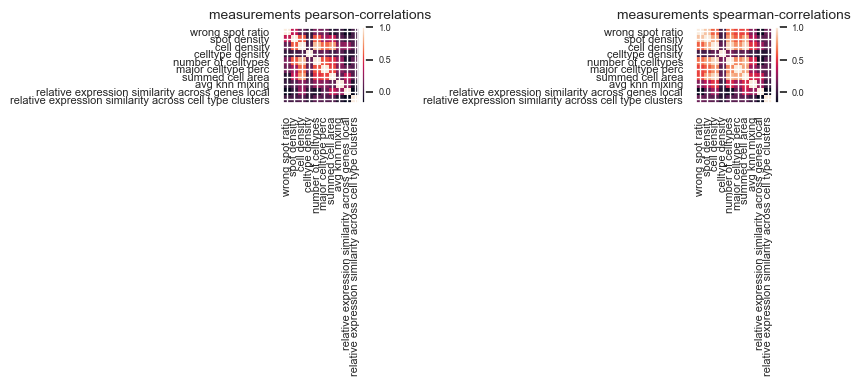

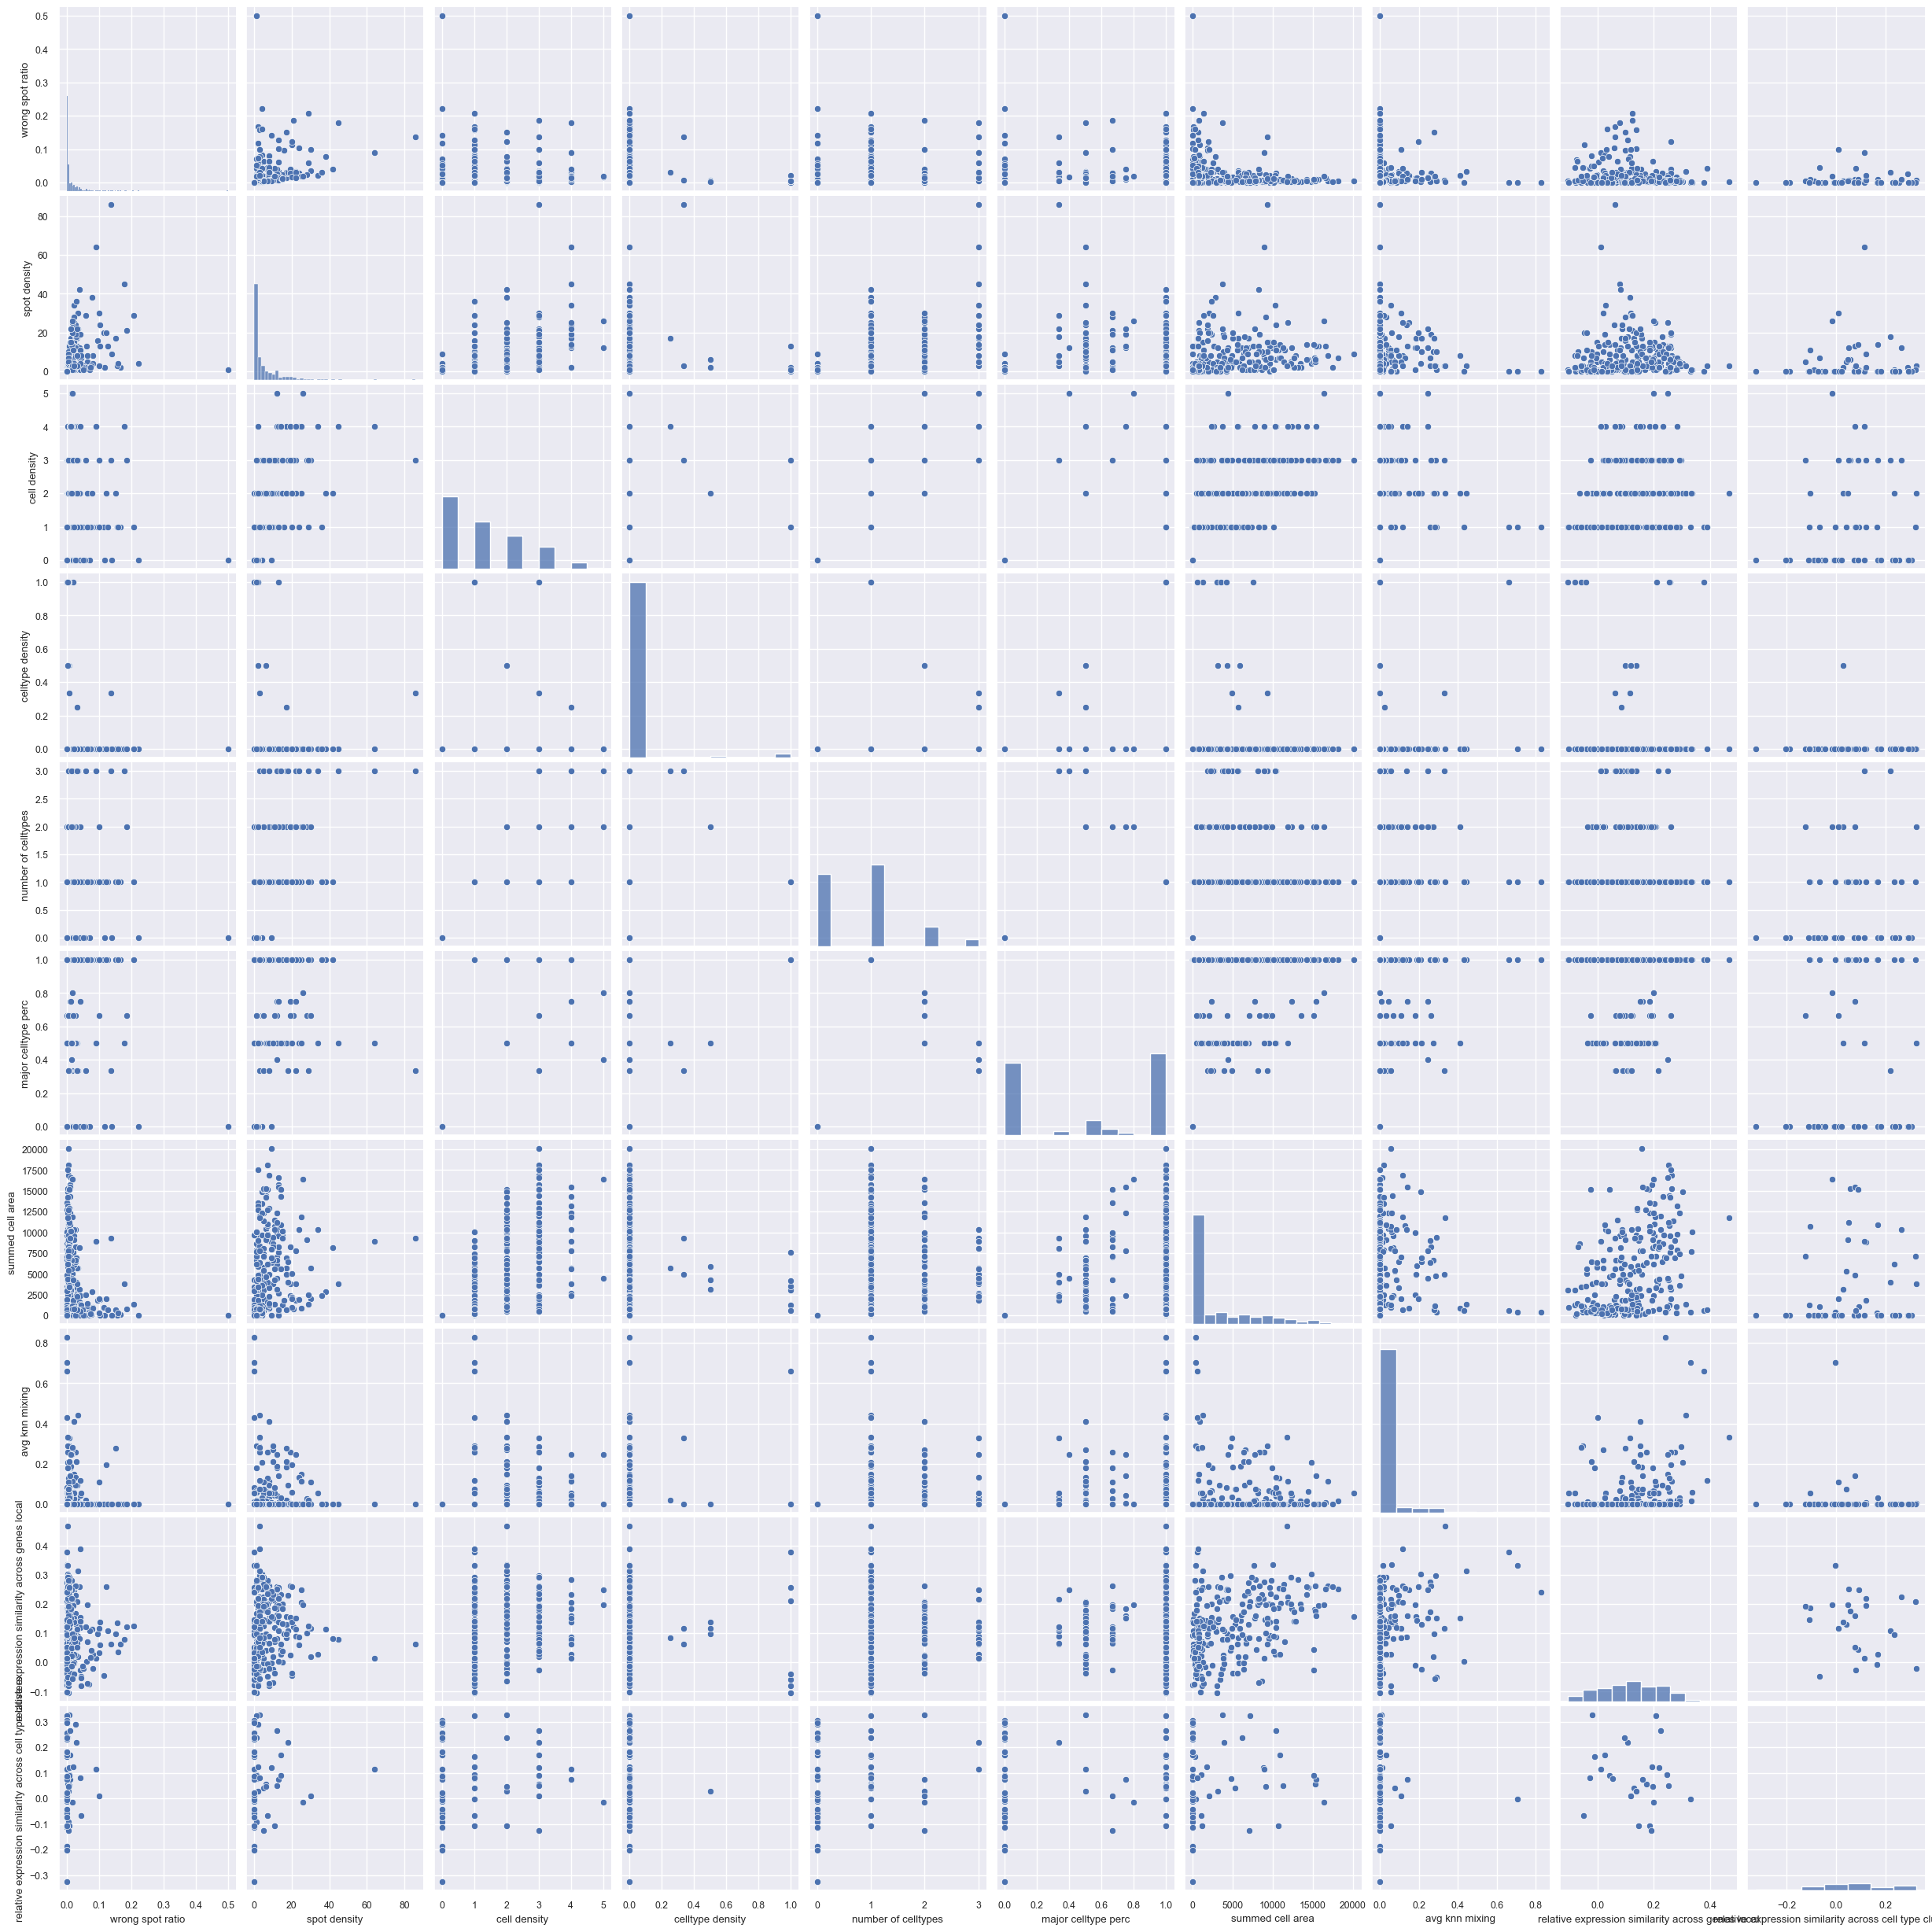

In [73]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("measurements pearson-correlations", fontsize = 10)
ax2.set_title("measurements spearman-correlations", fontsize = 10)
plot1 = ax1.imshow(pearson_corr_matrix)
plot2 = ax2.imshow(spearman_corr_matrix)

labels = ["wrong spot ratio","spot density","cell density", "celltype density",
        "number of celltypes","major celltype perc","summed cell area", "avg knn mixing", "relative expression similarity across genes local",
        "relative expression similarity across cell type clusters"]
for ax in [ax1,ax2]:
    ax.set_xticks(np.arange(len(labels)),labels)
    ax.set_yticks(np.arange(len(labels)),labels)
    ax.set_xticklabels(labels, rotation=90)
    ax.tick_params(axis="x",labelsize=8)
    ax.tick_params(axis="y",labelsize=8)
    
fig.colorbar(plot1,fraction=0.046, pad=0.04)    
fig.colorbar(plot2,fraction=0.046, pad=0.04)    

plt.subplots_adjust(wspace=4)        

sns.set(font_scale=0.8)
sns.pairplot(measurements_df)